In [22]:
import networkx as nx
import numpy as np
import random
import scipy.sparse as sp
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm
from pyrwr.ppr import PPR

# Create a smaller graph with evident subnetworks
G = nx.Graph()
edges = [
  (1, 2), (1, 3), (2, 3),  # Subnetwork 1
  (4, 5), (4, 6), (5, 6),  # Subnetwork 2
  (7, 8), (7, 9), (8, 9),  # Subnetwork 3
  (10, 11), (10, 12), (11, 12),  # Subnetwork 4
  (3, 12), (3, 9), (12, 9)  # Interconnections
]
G.add_edges_from(edges)

# Save the graph to file
graph_file = "toy_graph_edges.tsv"
#save_graph_to_file(G, graph_file)

nodes = list(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

deg_matrix = sp.diags([G.degree(n) for n in nodes])
adj_matrix = nx.to_scipy_sparse_array(G, nodelist=nodes, format='csr')

# Assign random seed scores
seed_scores = {node: random.uniform(0, 100) for node in nodes}

ppr = PPR()
ppr.read_graph(graph_file, graph_type="undirected")
r = ppr.compute(seed_scores, c=0.5, epsilon=1e-5, max_iters=200)
r

The iteration has converged at 1-iter:   0%|          | 1/200 [00:00<00:00, 300.13it/s]


array([0.07291667, 0.07291667, 0.10416667, 0.08333333, 0.08333333,
       0.08333333, 0.07291667, 0.07291667, 0.10416667, 0.07291667,
       0.07291667, 0.10416667])

In [23]:
seed_scores

{1: 9.99533001786106,
 2: 31.672664122901185,
 3: 88.13425717942567,
 4: 19.26505065823818,
 5: 10.11488423384258,
 6: 85.33265597247002,
 7: 74.45035849438922,
 8: 48.60164363948526,
 9: 65.69978739767276,
 10: 13.606915344518622,
 11: 72.66315807289828,
 12: 6.137173840552523}

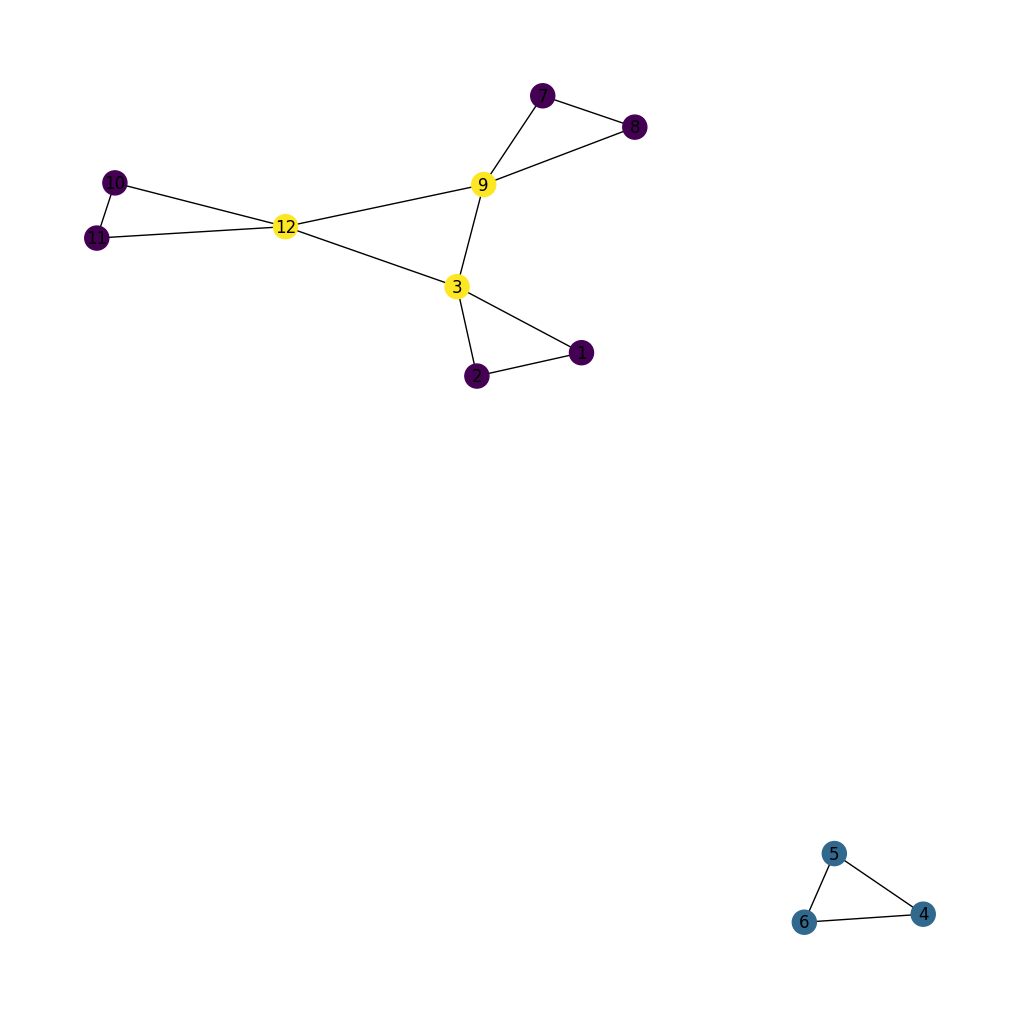

In [24]:
# visualize G with node colors based on the PPR scores
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nodes_color = [r[node_index[node]] for node in nodes]
nx.draw(G, pos, node_color=nodes_color, cmap='viridis', with_labels=True)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(nodes_color), vmax=max(nodes_color)))
sm.set_array([])


plt.show()


In [38]:
import networkx as nx
import numpy as np
import random
import scipy.sparse as sp
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm
from pyrwr.ppr import PPR

def save_graph_to_file(G, file_path):
    """Save the graph as an edge list file."""
    with open(file_path, 'w') as f:
        for u, v in G.edges():
            f.write(f"{u}\t{v}\t1.0\n")

def get_connected_components(adj_matrix):
    """Find connected components using sparse matrix operations."""
    _, labels = sp.csgraph.connected_components(adj_matrix, directed=False)
    return labels

def compute_subnetwork_scores(adj_matrix, scores):
    """Compute subnetwork scores using connected components."""
    labels = get_connected_components(adj_matrix)
    unique_labels, sums = np.unique(labels, return_counts=False), np.zeros(labels.max() + 1)

    np.add.at(sums, labels, scores)
    return sums, labels

def permuted_max_score(adj_matrix, scores):
    """Shuffle scores and return the max subnetwork score."""
    random.shuffle(scores)
    return max(compute_subnetwork_scores(adj_matrix, scores)[0])

def generate_null_distribution(adj_matrix, scores, n_permutations=1000, n_jobs=-1):
    """Parallelized null distribution computation."""
    return Parallel(n_jobs=n_jobs)(
        delayed(permuted_max_score)(adj_matrix, scores.copy()) for _ in range(n_permutations)
    )

def compute_p_values(actual_scores, null_distribution):
    """Compute p-values without multiple testing correction."""
    null_distribution = np.array(null_distribution)
    p_values = [(np.sum(null_distribution >= score) + 1) / (len(null_distribution) + 1) for score in actual_scores]
    return np.array(p_values)

def compute_ppr_scores(graph_file, seed_scores, restart_prob=0.85, epsilon=1e-6, max_iters=100):
    """Compute PPR-based node scores using pyrwr.PPR."""
    ppr = PPR()
    ppr.read_graph(graph_file, graph_type="undirected")
    
    seeds = list(seed_scores.keys())  # Use multiple seeds
    ppr_scores = ppr.compute(seeds, c=restart_prob, epsilon=epsilon, max_iters=max_iters)
    return np.array(ppr_scores)

def find_significant_subnetworks(graph_file, seed_scores, adj_matrix, nodes, alpha=0.05, n_permutations=1000, max_subnetwork_size=50):
    """Find significant subnetworks using PPR-based scores."""
    scores = compute_ppr_scores(graph_file, seed_scores)
    actual_scores, labels = compute_subnetwork_scores(adj_matrix, scores)
    null_distribution = generate_null_distribution(adj_matrix, scores, n_permutations)
    p_values = compute_p_values(actual_scores, null_distribution)
    threshold = np.percentile(null_distribution, 100 * (1 - alpha))

    significant_subnetworks = []
    for i, (score, p_val) in enumerate(zip(actual_scores, p_values)):
        if p_val < alpha:
            significant_nodes = [nodes[j] for j in range(len(nodes)) if labels[j] == i]
            if len(significant_nodes) <= max_subnetwork_size:
                significant_subnetworks.append({"nodes": significant_nodes, "score": score, "p_value": p_val})
    
    subnetwork_df = pd.DataFrame(significant_subnetworks)
    return subnetwork_df, threshold

# Example Usage
graph_file = "graph_edges.tsv"
G = nx.erdos_renyi_graph(500, 0.01)
save_graph_to_file(G, graph_file)

nodes = list(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

deg_matrix = sp.diags([G.degree(n) for n in nodes])
adj_matrix = nx.to_scipy_sparse_array(G, nodelist=nodes, format='csr')

seed_scores = {random.choice(nodes): random.uniform(0, 1) for _ in range(100)}

significant_subnetworks_df, threshold = find_significant_subnetworks(graph_file, seed_scores, adj_matrix, nodes, max_subnetwork_size=50)
print(f"Found {len(significant_subnetworks_df)} significant subnetworks.")
print(significant_subnetworks_df.head())
print(f"Threshold Score: {threshold:.2f}")



The iteration has converged at 6-iter:   6%|▌         | 6/100 [00:00<00:00, 674.61it/s]


Found 0 significant subnetworks.
Empty DataFrame
Columns: []
Index: []
Threshold Score: 1.00


In [1]:
import networkx as nx
import numpy as np
import random
import scipy.sparse as sp
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm
from pyrwr.ppr import PPR

def save_graph_to_file(G, file_path):
    """Save the graph as an edge list file."""
    with open(file_path, 'w') as f:
        for u, v in G.edges():
            f.write(f"{u}\t{v}\t1.0\n")

def get_connected_components(adj_matrix):
    """Find connected components using sparse matrix operations."""
    _, labels = sp.csgraph.connected_components(adj_matrix, directed=False)
    return labels

def compute_subnetwork_scores(adj_matrix, scores):
    """Compute subnetwork scores using connected components."""
    labels = get_connected_components(adj_matrix)
    unique_labels, sums = np.unique(labels, return_counts=False), np.zeros(labels.max() + 1)

    np.add.at(sums, labels, scores)
    return sums, labels

def permuted_max_score(adj_matrix, scores):
    """Shuffle scores and return the max subnetwork score."""
    random.shuffle(scores)
    return max(compute_subnetwork_scores(adj_matrix, scores)[0])

def permuted_network_max_score(G, seed_scores):
    """Randomly rewire the network and compute max subnetwork score."""
    G_permuted = G.copy()
    nx.double_edge_swap(G_permuted, nswap=len(G.edges()) // 2, max_tries=len(G.edges()) * 10)
    
    # Save permuted network
    graph_file = "graph_permuted.tsv"
    save_graph_to_file(G_permuted, graph_file)
    
    # Compute new adjacency matrix
    nodes = list(G_permuted.nodes())
    adj_matrix = nx.to_scipy_sparse_array(G_permuted, nodelist=nodes, format='csr')
    
    # Compute PPR scores on permuted network
    scores = compute_ppr_scores(graph_file, seed_scores)
    return max(compute_subnetwork_scores(adj_matrix, scores)[0])

def generate_null_distribution(adj_matrix, scores, G, seed_scores, n_permutations=1000, n_jobs=-1):
    """Parallelized null distribution computation with both node score and network permutations."""
    node_score_permutations = Parallel(n_jobs=n_jobs)(
        delayed(permuted_max_score)(adj_matrix, scores.copy()) for _ in range(n_permutations // 2)
    )
    network_permutations = Parallel(n_jobs=n_jobs)(
        delayed(permuted_network_max_score)(G, seed_scores) for _ in range(n_permutations // 2)
    )
    return node_score_permutations + network_permutations

def compute_p_values(actual_scores, null_distribution):
    """Compute p-values without multiple testing correction."""
    null_distribution = np.array(null_distribution)
    p_values = [(np.sum(null_distribution >= score) + 1) / (len(null_distribution) + 1) for score in actual_scores]
    return np.array(p_values)

def compute_ppr_scores(graph_file, seed_scores, restart_prob=0.85, epsilon=1e-6, max_iters=100):
    """Compute PPR-based node scores using pyrwr.PPR."""
    ppr = PPR()
    ppr.read_graph(graph_file, graph_type="undirected")
    
    seeds = list(seed_scores.keys())  # Use multiple seeds
    ppr_scores = ppr.compute(seeds, c=restart_prob, epsilon=epsilon, max_iters=max_iters)
    return np.array(ppr_scores)

def find_significant_subnetworks(graph_file, seed_scores, adj_matrix, G, nodes, alpha=0.05, n_permutations=1000, max_subnetwork_size=50):
    """Find significant subnetworks using PPR-based scores."""
    scores = compute_ppr_scores(graph_file, seed_scores)
    actual_scores, labels = compute_subnetwork_scores(adj_matrix, scores)
    null_distribution = generate_null_distribution(adj_matrix, scores, G, seed_scores, n_permutations)
    p_values = compute_p_values(actual_scores, null_distribution)
    threshold = np.percentile(null_distribution, 100 * (1 - alpha))

    significant_subnetworks = []
    for i, (score, p_val) in enumerate(zip(actual_scores, p_values)):
        if p_val < alpha:
            significant_nodes = [nodes[j] for j in range(len(nodes)) if labels[j] == i]
            if len(significant_nodes) <= max_subnetwork_size:
                significant_subnetworks.append({"nodes": significant_nodes, "score": score, "p_value": p_val})
    
    subnetwork_df = pd.DataFrame(significant_subnetworks)
    return subnetwork_df, threshold

# Example Usage
graph_file = "graph_edges.tsv"
G = nx.erdos_renyi_graph(5000, 0.001)
save_graph_to_file(G, graph_file)

nodes = list(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

deg_matrix = sp.diags([G.degree(n) for n in nodes])
adj_matrix = nx.to_scipy_sparse_array(G, nodelist=nodes, format='csr')

seed_scores = {random.choice(nodes): random.uniform(0, 1) for _ in range(10)}

significant_subnetworks_df, threshold = find_significant_subnetworks(graph_file, seed_scores, adj_matrix, G, nodes, max_subnetwork_size=50)
print(f"Found {len(significant_subnetworks_df)} significant subnetworks.")
print(significant_subnetworks_df.head())
print(f"Threshold Score: {threshold:.2f}")


The iteration has converged at 7-iter:   7%|▋         | 7/100 [00:00<00:00, 3182.32it/s]


ValueError: array is not broadcastable to correct shape

In [12]:
import numpy as np
import networkx as nx
import json
import os
from multiprocessing import Pool
from itertools import islice


# Load network and heat scores

def load_heat_scores(heat_file):
    """Load heat scores from a JSON file."""
    with open(heat_file, 'r') as f:
        heat_scores = json.load(f)
    return heat_scores

def load_network(network_file):
    """Load a protein-protein interaction network from an edge list."""
    G = nx.read_edgelist(network_file, nodetype=str)
    return G

def compute_influence_matrix(G):
    """Compute the influence matrix of the network using shortest path lengths."""
    return nx.floyd_warshall_numpy(G)


# Identify subnetworks with high mutation heat

def identify_hot_subnetworks(G, heat_scores, influence_matrix, threshold=0.5):
    """Identify subnetworks with high mutation heat."""
    hot_nodes = {node for node, heat in heat_scores.items() if heat > threshold}
    subgraph = G.subgraph(hot_nodes)
    return [list(component) for component in nx.connected_components(subgraph)]


# Permutation functions

def heat_permutation_wrapper(heat_scores, eligible_genes):
    """Shuffle the heat scores."""
    permuted_genes = np.random.choice(eligible_genes, len(heat_scores), replace=False)
    permuted_heat = dict(zip(permuted_genes, heat_scores))
    return permuted_heat

def permute_heat(heat, network_genes, num_permutations, addtl_genes=None, num_cores=1):
    """Return a list of num_permutation dicts, each mapping gene names to permuted heat scores."""
    if num_cores > 1:
        with Pool(num_cores) as pool:
            args = [(list(heat.values()), list(set(heat.keys()).union(addtl_genes).intersection(network_genes)))] * num_permutations
            permutations = pool.starmap(heat_permutation_wrapper, args)
    else:
        permutations = [heat_permutation_wrapper(list(heat.values()), list(set(heat.keys()).union(addtl_genes).intersection(network_genes))) for _ in range(num_permutations)]

    return permutations


def permute_network(G):
    """Randomly rewire network edges while preserving degree distribution."""
    return nx.double_edge_swap(G, nswap=len(G.edges()) * 2, max_tries=len(G.edges()) * 10)


# Significance Testing

def compute_significance(G, heat_scores, influence_matrix, num_permutations=100):
    """Compute significance of subnetworks by permutation testing."""
    original_subnetworks = identify_hot_subnetworks(G, heat_scores, influence_matrix)
    null_distributions = []
    
    for _ in range(num_permutations):
        permuted_heat = permute_heat(heat_scores, list(G.nodes()), 1)[0]  # Generate a single permutation
        permuted_network = permute_network(G)
        permuted_influence = compute_influence_matrix(permuted_network)
        permuted_subnetworks = identify_hot_subnetworks(permuted_network, permuted_heat, permuted_influence)
        null_distributions.append(len(permuted_subnetworks))
    
    p_value = sum(len(original_subnetworks) <= n for n in null_distributions) / num_permutations
    return {"subnetworks": original_subnetworks, "p_value": p_value}


# Main function to run HotNet2

def run_hotnet2(network_files, heat_files, output_directory, num_processes=4, num_permutations=100):
    """Run HotNet2 on multiple networks and heat files."""
    os.makedirs(output_directory, exist_ok=True)
    
    for network_file, heat_file in zip(network_files, heat_files):
        print(f"Processing {network_file} with {heat_file}")
        G = load_network(network_file)
        heat_scores = load_heat_scores(heat_file)
        influence_matrix = compute_influence_matrix(G)
        
        with Pool(num_processes) as pool:
            results = pool.starmap(compute_significance, [(G, heat_scores, influence_matrix, num_permutations)])
        
        output_file = os.path.join(output_directory, f"{os.path.basename(network_file)}_results.json")
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=4)
        
        print(f"Results saved to {output_file}")


# Toy example to test the setup

if __name__ == "__main__":
    toy_network = nx.erdos_renyi_graph(100, 0.05)
    nx.write_edgelist(toy_network, "toy_network.txt", data=False)
    
    heat_scores = {str(node): np.random.rand() for node in toy_network.nodes()}
    with open("toy_heat.json", 'w') as f:
        json.dump(heat_scores, f)
    
    run_hotnet2(["toy_network.txt"], ["toy_heat.json"], "output")


Processing toy_network.txt with toy_heat.json


TypeError: 'NoneType' object is not iterable